# Load and Explore Dataset
Load the emissions dataset using pandas, display the first few rows, and check for missing values.

In [2]:
import pandas as pd

# Load the emissions dataset
file_path = '/Users/admin/Documents/Programming/ds-and-ml-python/handsOnML/dsci_sem_draft_01/emissions.csv'
emissions_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(emissions_data.head())

# Check for missing values
print(emissions_data.isnull().sum())

   year state-name                                      sector-name  \
0  1970    Alabama              Industrial carbon dioxide emissions   
1  1970    Alabama              Industrial carbon dioxide emissions   
2  1970    Alabama              Industrial carbon dioxide emissions   
3  1970    Alabama              Industrial carbon dioxide emissions   
4  1970    Alabama  Total carbon dioxide emissions from all sectors   

     fuel-name       value  
0         Coal   26.721507  
1    Petroleum    3.577779  
2  Natural Gas    8.944097  
3    All Fuels   39.243383  
4    All Fuels  102.646851  
year           0
state-name     0
sector-name    0
fuel-name      0
value          0
dtype: int64


# Preprocess Data
Filter the dataset for relevant columns (e.g., 'year', 'state-name', 'value'), handle missing values, and encode categorical variables if necessary.

In [3]:
# Filter the dataset for relevant columns
filtered_data = emissions_data[['year', 'state-name', 'value']]

# Drop rows with missing values
filtered_data = filtered_data.dropna()

# Encode the 'state-name' column using one-hot encoding
encoded_data = pd.get_dummies(filtered_data, columns=['state-name'], prefix='state')

# Display the first few rows of the preprocessed dataset
print(encoded_data.head())

   year       value  state_Alabama  state_Alaska  state_Arizona  \
0  1970   26.721507              1             0              0   
1  1970    3.577779              1             0              0   
2  1970    8.944097              1             0              0   
3  1970   39.243383              1             0              0   
4  1970  102.646851              1             0              0   

   state_Arkansas  state_California  state_Colorado  state_Connecticut  \
0               0                 0               0                  0   
1               0                 0               0                  0   
2               0                 0               0                  0   
3               0                 0               0                  0   
4               0                 0               0                  0   

   state_Delaware  ...  state_Tennessee  state_Texas  state_United States  \
0               0  ...                0            0                    0  

# Feature Scaling
Scale the 'value' column using MinMaxScaler to normalize the data for the RNN.

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the 'value' column
encoded_data['value'] = scaler.fit_transform(encoded_data[['value']])

# Display the first few rows of the dataset after scaling
print(encoded_data.head())

   year     value  state_Alabama  state_Alaska  state_Arizona  state_Arkansas  \
0  1970  0.004456              1             0              0               0   
1  1970  0.000597              1             0              0               0   
2  1970  0.001492              1             0              0               0   
3  1970  0.006544              1             0              0               0   
4  1970  0.017118              1             0              0               0   

   state_California  state_Colorado  state_Connecticut  state_Delaware  ...  \
0                 0               0                  0               0  ...   
1                 0               0                  0               0  ...   
2                 0               0                  0               0  ...   
3                 0               0                  0               0  ...   
4                 0               0                  0               0  ...   

   state_Tennessee  state_Texas  state

# Prepare Data for RNN
Reshape the data into sequences suitable for RNN input, splitting into training and testing datasets.

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

# Prepare the data for RNN
# Sort the data by year to maintain temporal order
encoded_data = encoded_data.sort_values(by='year')

# Convert the data into sequences
sequence_length = 5  # Number of time steps in each sequence
features = encoded_data.drop(columns=['year']).values
sequences = []
targets = []

for i in range(len(features) - sequence_length):
    sequences.append(features[i:i + sequence_length])
    targets.append(features[i + sequence_length, 0])  # Assuming 'value' is the target column

sequences = np.array(sequences)
targets = np.array(targets)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42, shuffle=False)

# Print the shapes of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (47916, 5, 53)
X_test shape: (11980, 5, 53)
y_train shape: (47916,)
y_test shape: (11980,)


# Build the RNN Model
Use TensorFlow/Keras to define an RNN model with LSTM or GRU layers, followed by dense layers.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the RNN model
model = Sequential()

# Add an LSTM layer with 50 units and return sequences for stacking
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Add another LSTM layer with 50 units
model.add(LSTM(50, return_sequences=False))

# Add another dropout layer
model.add(Dropout(0.2))

# Add a dense layer with 25 units
model.add(Dense(25, activation='relu'))

# Add the output layer with 1 unit (for regression)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             20800     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 42,301
Trainable params: 42,301
Non-traina

# Train the RNN Model
Compile the model, specify the loss function and optimizer, and train the model using the training data.

Epoch 1/50


2025-04-04 15:44:02.240880: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1498/1498 [==============================] - 6s 3ms/step - loss: 9.8217e-04 - val_loss: 0.0011
Epoch 2/50
1498/1498 [==============================] - 4s 3ms/step - loss: 9.1349e-04 - val_loss: 0.0010
Epoch 3/50
1498/1498 [==============================] - 4s 3ms/step - loss: 8.9745e-04 - val_loss: 9.6178e-04
Epoch 4/50
1498/1498 [==============================] - 4s 3ms/step - loss: 8.8690e-04 - val_loss: 9.4400e-04
Epoch 5/50
1498/1498 [==============================] - 5s 3ms/step - loss: 8.9634e-04 - val_loss: 9.5743e-04
Epoch 6/50
1498/1498 [==============================] - 4s 3ms/step - loss: 8.8918e-04 - val_loss: 9.3868e-04
Epoch 7/50
1498/1498 [==============================] - 5s 3ms/step - loss: 8.8501e-04 - val_loss: 9.2805e-04
Epoch 8/50
1498/1498 [==============================] - 5s 3ms/step - loss: 8.8076e-04 - val_loss: 9.5010e-04
Epoch 9/50
1498/1498 [==============================] - 5s 3ms/step - loss: 8.6876e-04 - val_loss: 9.7491e-04
Epoch 10/50
1498/1498 [======

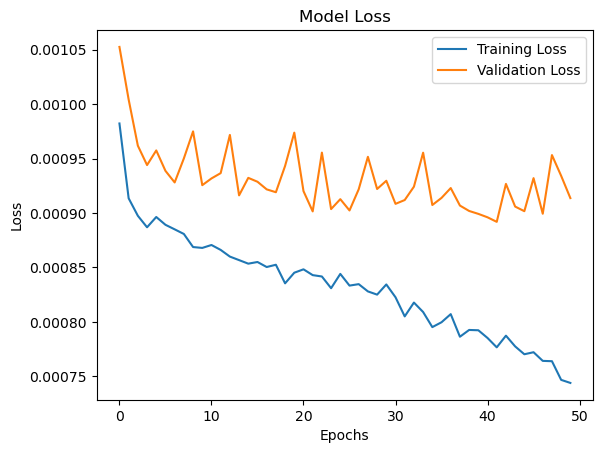

In [7]:
# Train the RNN model
# Specify the number of epochs and batch size
epochs = 50
batch_size = 32

# Train the model using the training data
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the Model
Evaluate the model's performance on the test data using metrics like Mean Squared Error (MSE).

375/375 [==============================] - 1s 802us/step
Mean Squared Error (MSE) on Test Data: 0.0009136866432131684


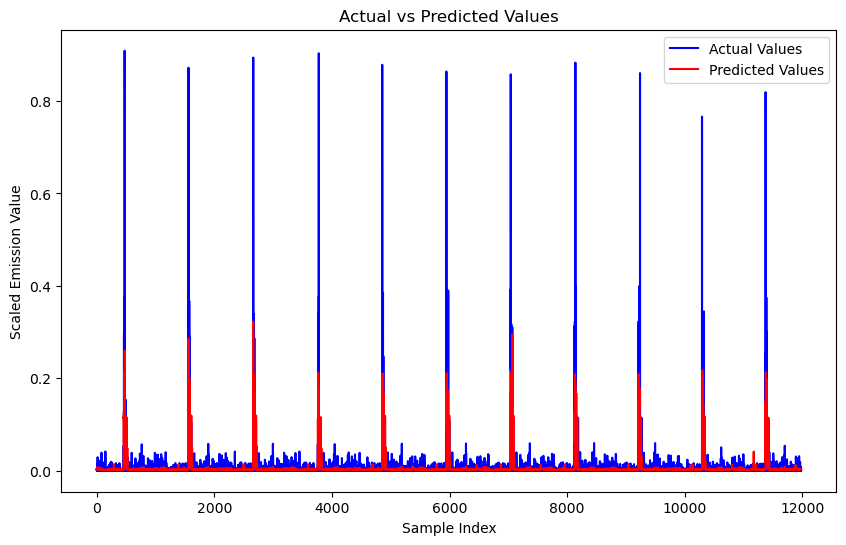

In [8]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict the target values for the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Print the MSE
print(f"Mean Squared Error (MSE) on Test Data: {mse}")

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(y_pred, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Scaled Emission Value')
plt.legend()
plt.show()

# Make Predictions
Use the trained model to make predictions on new or test data and visualize the results.

375/375 [==============================] - 0s 946us/step


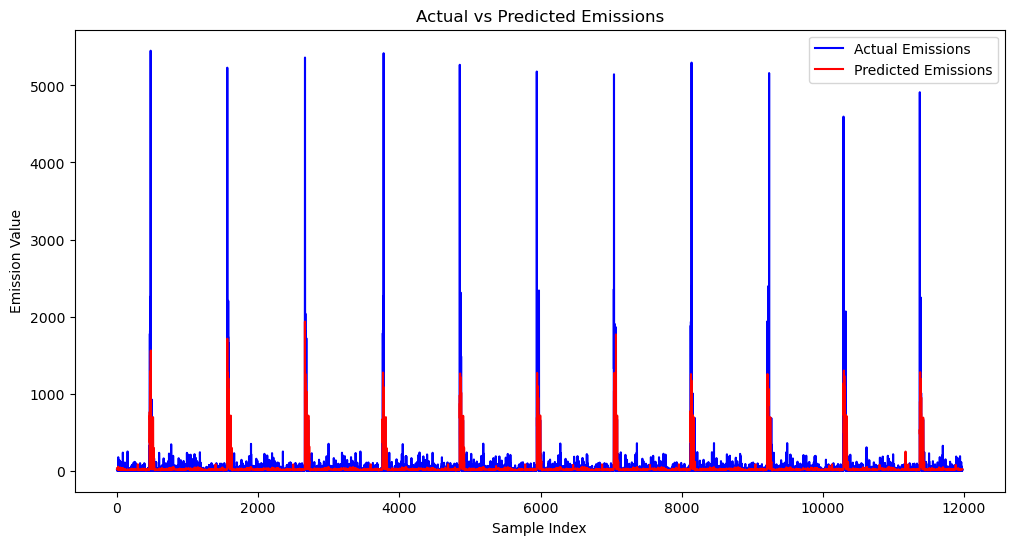

In [9]:
# Use the trained model to make predictions on new or test data
# Predict the target values for the test set
y_pred = model.predict(X_test)

# Rescale the predicted and actual values back to their original scale
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Emissions', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Emissions', color='red')
plt.title('Actual vs Predicted Emissions')
plt.xlabel('Sample Index')
plt.ylabel('Emission Value')
plt.legend()
plt.show()

# Save the model for future use
model.save('./models/emissions_rnn_model.h5')